In [1]:
import os
import json
import hashlib
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from datasets import Dataset, DatasetDict, concatenate_datasets, Audio, ClassLabel, Features, Value, Array2D
from transformers import ASTFeatureExtractor

In [2]:
music_lib: dict[str, list[str]] = {}
def add_songs(dir: str, skip_dirs: list[str] = [], genre: str = ""):
    for dirent in os.listdir(dir): 
        path = os.path.join(dir, dirent)
        if os.path.isdir(path) and dirent not in skip_dirs:
            add_songs(path, genre=genre if genre else dirent)
        elif os.path.isfile(path) and path.endswith(".mp3"):
            if genre not in music_lib:
                music_lib[genre] = []
            music_lib[genre].append(path)

add_songs("D:\\Music", ["$RECYCLE.BIN", "downloads", "Eigenes", "Hörbücher", "Mixes", "System Volume Information"])
for genre, songs in list(music_lib.items()):
    if len(songs) < 6: # at leat one in each dataset 
        del music_lib[genre]
    else:
        print(f"{genre}: {len(songs)} songs")

Bad: 303 songs
Bassy: 24 songs
Big Room: 58 songs
Bounce: 158 songs
Chill: 39 songs
Chillstep: 31 songs
Classic: 82 songs
Coding: 11 songs
Country: 90 songs
Cro: 55 songs
Deep House: 37 songs
Drum and Bass: 47 songs
Dubstep: 35 songs
EDM: 52 songs
Electro: 176 songs
Electro House: 112 songs
Emotional: 23 songs
Epic: 12 songs
Folk: 6 songs
Frenchcore: 65 songs
Glitch Hop: 31 songs
God: 20 songs
Groove: 101 songs
Hands Up: 1373 songs
Hardcore: 156 songs
Hardstyle: 222 songs
Harp: 6 songs
Hip Hop & Rap: 112 songs
Historic: 17 songs
Latino: 41 songs
Lounge: 105 songs
Malle: 90 songs
Minimal: 38 songs
Motivation: 114 songs
Orchestra Pop: 23 songs
Orchestral Electro: 30 songs
OVERWERK: 11 songs
Pop: 7 songs
Pop mit Beat: 18 songs
Psy: 67 songs
Psytrance: 9 songs
RnB: 42 songs
Rock: 174 songs
Synthpop: 6 songs
Techno: 124 songs
Tekk: 28 songs
Trance: 301 songs
Weihnachten: 21 songs


In [3]:
genres = list(music_lib.keys())
filepaths: list[str] = []
labels: list[int] = []
for genre_idx, songs in enumerate(music_lib.values()):
    for filepath in songs:
        filepaths.append(filepath)
        labels.append(genre_idx)

In [4]:
with open("../dataset/genres.json", "w+", encoding="utf-8") as f:
    json.dump(genres, f, ensure_ascii=False)

In [22]:
pretrained_model = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = ASTFeatureExtractor.from_pretrained(pretrained_model)
feature_extractor.max_length = 498

model_input_name = feature_extractor.model_input_names[0]
labels_name = "labels"
paths_name = "paths"

d:\Development\monorepo\.venv\Lib\site-packages\transformers\audio_utils.py:297: UserWarning: At least one mel filter has all zero values. The value for `num_mel_filters` (128) may be set too high. Or, the value for `num_frequency_bins` (256) may be set too low.
  warnings.warn(


In [6]:
def hash_dict(d):
    dict_tuple = tuple(sorted(d.items()))
    return hashlib.sha256(repr(dict_tuple).encode()).hexdigest()[:48]

music_lib_hash = hash_dict(music_lib)

In [7]:
features = Features({
    model_input_name: Audio(sampling_rate=feature_extractor.sampling_rate),
    labels_name: ClassLabel(names=genres)
})

tmp_features = Features({
    model_input_name: Value("string"),
    labels_name: ClassLabel(names=genres)
})

dataset = Dataset.from_dict({
    model_input_name: filepaths,
    labels_name: labels,
}, features=tmp_features).train_test_split(
    test_size=0.3,
    shuffle=True,
    stratify_by_column=labels_name,
    load_from_cache_file=True,
    train_indices_cache_file_name="../cache/train_indices",
    test_indices_cache_file_name="../cache/validate_test_indices",
    train_new_fingerprint=f"train_{music_lib_hash}",
    test_new_fingerprint=f"validate_test_{music_lib_hash}"
)

validation_dataset = dataset["test"].train_test_split(
    test_size=2/3,
    shuffle=True,
    stratify_by_column=labels_name,
    load_from_cache_file=True,
    train_indices_cache_file_name="../cache/validate_indices",
    test_indices_cache_file_name="../cache/test_indices",
    train_new_fingerprint=f"validate_{music_lib_hash}",
    test_new_fingerprint=f"test_{music_lib_hash}"
)

dataset["validate"] = validation_dataset["train"]
dataset["test"] = validation_dataset["test"]

dataset = dataset.cast(features)
dataset

Casting the dataset:   0%|          | 0/3292 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/941 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/470 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 3292
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 941
    })
    validate: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 470
    })
})

In [23]:
sample_len_sec = 5
sample_start_times = [0, 30, 60, 90, 120]
def preprocess_song(song):
    audio = song[model_input_name]
    sampling_rate = audio["sampling_rate"]
    wav = audio["array"]
    song_spetrograms = []
    song_labels = []
    song_paths = []
    for sample_start_time in sample_start_times:
        start_sample = sample_start_time * sampling_rate
        end_sample = (sample_start_time + sample_len_sec) * sampling_rate
        if end_sample >= len(wav):
            break
        input_wav = wav[start_sample:end_sample]
        song_spetrograms.append(feature_extractor(input_wav, sampling_rate=sampling_rate, return_tensors="pt")[model_input_name][0])
        song_labels.append(song[labels_name])
        song_paths.append(audio["path"])
    
    return song_spetrograms, song_labels, song_paths

In [26]:
spectrogram_features = Features({
    model_input_name: Array2D(shape=(feature_extractor.max_length, feature_extractor.num_mel_bins), dtype="float32"),
    labels_name: ClassLabel(names=genres),
    paths_name: Value(dtype="string")
})

for split, sub_dataset in dataset.items():
    batch_size = 2_000
    batch_spectrograms = []
    batch_labels = []
    batch_paths = []
    def save_batch(idx: int):
        batch_dict = {model_input_name: batch_spectrograms, labels_name: batch_labels, paths_name: batch_paths}
        partial_dataset = Dataset.from_dict(batch_dict, features=spectrogram_features)
        partial_dataset.save_to_disk(f"../spectrums/{split}_batch_{idx}")

    idx = 0
    for song in tqdm(sub_dataset, desc=f"Preparing {split} spectrums", total=len(sub_dataset)):
        song_spectrograms, song_labels, song_paths = preprocess_song(song)
        batch_spectrograms = [*batch_spectrograms, *song_spectrograms]
        batch_labels = [*batch_labels, *song_labels]
        batch_paths = [*batch_paths, *song_paths]
        if len(batch_spectrograms) >= batch_size:
            save_batch(idx)
            batch_spectrograms = []
            batch_labels = []
            batch_paths = []
            idx += 1
    save_batch(idx)

Preparing train spectrums:  12%|█▏        | 402/3292 [04:56<34:59,  1.38it/s]

Saving the dataset (0/2 shards):   0%|          | 0/2001 [00:00<?, ? examples/s]

Preparing train spectrums:  24%|██▍       | 804/3292 [10:20<31:00,  1.34it/s]  

Saving the dataset (0/2 shards):   0%|          | 0/2003 [00:00<?, ? examples/s]

Preparing train spectrums:  37%|███▋      | 1206/3292 [15:49<30:15,  1.15it/s] 

Saving the dataset (0/2 shards):   0%|          | 0/2002 [00:00<?, ? examples/s]

Preparing train spectrums:  49%|████▉     | 1608/3292 [21:23<18:24,  1.53it/s]  

Saving the dataset (0/2 shards):   0%|          | 0/2004 [00:00<?, ? examples/s]

Preparing train spectrums:  61%|██████    | 2010/3292 [26:33<14:04,  1.52it/s]  

Saving the dataset (0/2 shards):   0%|          | 0/2002 [00:00<?, ? examples/s]

Preparing train spectrums:  73%|███████▎  | 2415/3292 [31:44<08:37,  1.70it/s]

Saving the dataset (0/2 shards):   0%|          | 0/2004 [00:00<?, ? examples/s]

Preparing train spectrums:  86%|████████▌ | 2817/3292 [37:12<06:08,  1.29it/s]  

Saving the dataset (0/2 shards):   0%|          | 0/2002 [00:00<?, ? examples/s]

Preparing train spectrums:  98%|█████████▊| 3219/3292 [42:13<00:47,  1.54it/s]

Saving the dataset (0/2 shards):   0%|          | 0/2002 [00:00<?, ? examples/s]

Preparing train spectrums: 100%|██████████| 3292/3292 [43:18<00:00,  1.27it/s]


Saving the dataset (0/1 shards):   0%|          | 0/358 [00:00<?, ? examples/s]

Preparing test spectrums:  43%|████▎     | 402/941 [05:01<07:15,  1.24it/s]

Saving the dataset (0/2 shards):   0%|          | 0/2002 [00:00<?, ? examples/s]

Preparing test spectrums:  86%|████████▌ | 805/941 [10:19<01:49,  1.24it/s]

Saving the dataset (0/2 shards):   0%|          | 0/2001 [00:00<?, ? examples/s]

Preparing test spectrums: 100%|██████████| 941/941 [12:10<00:00,  1.29it/s]


Saving the dataset (0/1 shards):   0%|          | 0/672 [00:00<?, ? examples/s]

Preparing validate spectrums:  85%|████████▌ | 401/470 [05:05<00:47,  1.45it/s]

Saving the dataset (0/2 shards):   0%|          | 0/2004 [00:00<?, ? examples/s]

Preparing validate spectrums: 100%|██████████| 470/470 [06:05<00:00,  1.29it/s]


Saving the dataset (0/1 shards):   0%|          | 0/338 [00:00<?, ? examples/s]

In [29]:
batch_paths = [f"../spectrums/{batch_dir}" for batch_dir in os.listdir("../spectrums")]

train_batches = [Dataset.load_from_disk(path) for path in batch_paths if "train" in path]
validate_batches = [Dataset.load_from_disk(path) for path in batch_paths if "validate" in path]
test_batches = [Dataset.load_from_disk(path) for path in batch_paths if "test" in path]

train_dataset = concatenate_datasets(train_batches)
validate_dataset = concatenate_datasets(validate_batches)
test_dataset = concatenate_datasets(test_batches)

preprocessed_dataset = DatasetDict({
    "train": train_dataset,
    "validate": validate_dataset,
    "test": test_dataset
})

In [30]:
preprocessed_dataset.save_to_disk("../dataset/music_lib")

Saving the dataset (0/9 shards):   0%|          | 0/16378 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/2342 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/4675 [00:00<?, ? examples/s]

In [31]:
preprocessed_dataset = DatasetDict.load_from_disk("../dataset/music_lib")
preprocessed_dataset

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels', 'paths'],
        num_rows: 16378
    })
    validate: Dataset({
        features: ['input_values', 'labels', 'paths'],
        num_rows: 2342
    })
    test: Dataset({
        features: ['input_values', 'labels', 'paths'],
        num_rows: 4675
    })
})

In [43]:
def visualize_spectrum(split_to_visualize: str, idx_to_visualize: int):
    print(preprocessed_dataset[split_to_visualize][idx_to_visualize]["paths"])
    print(preprocessed_dataset[split_to_visualize][idx_to_visualize]["labels"])
    spectrum = np.array(preprocessed_dataset[split_to_visualize][idx_to_visualize][model_input_name])
    
    plt.figure(figsize=(10, 6))
    plt.imshow(spectrum.T, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label="Amplitude")
    plt.xlabel("Time Frames")
    plt.ylabel("Frequency Bins")
    plt.title("Audio Spectrum")
    plt.tight_layout()
    plt.show()

D:\Music\Electro\Alan_Walker - 135.mp3
14


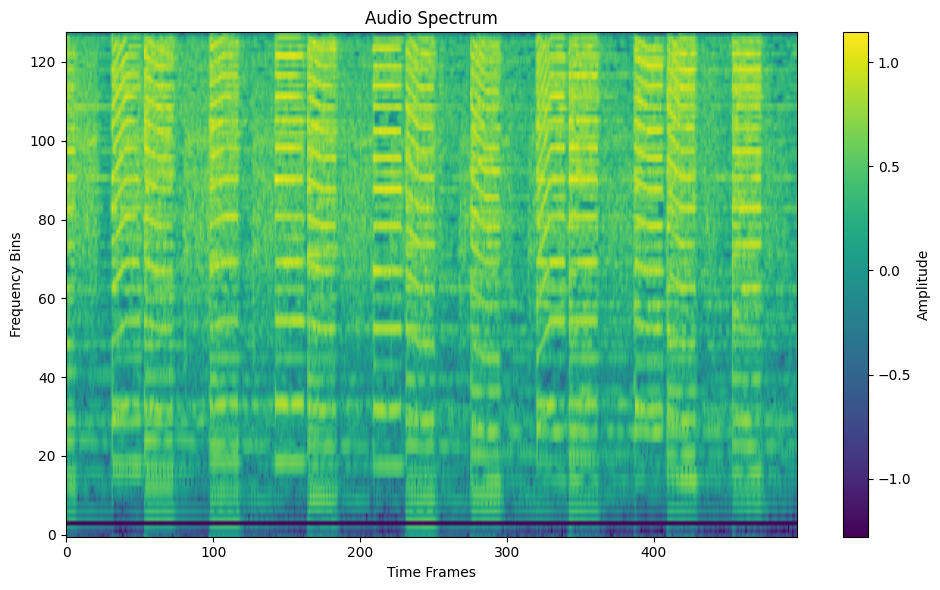

In [46]:
visualize_spectrum("train", 4)
